In [1]:
import scanpy as sc
import pandas as pd 
import numpy as np
import anndata
import re
import h5py
import scipy.sparse as scs
import concurrent.futures
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csc_matrix
from concurrent.futures import ThreadPoolExecutor, as_completed
import umap
import random
import multiprocessing
random.seed(123)
from joblib import Parallel, delayed
import copy
import os
from tqdm import tqdm
import math
import scanpy.external as sce
from concurrent.futures import ProcessPoolExecutor
from PIL import Image, ImageDraw, ImageFont
import gc
import re
import multiprocessing


In [2]:
def run_leiden(adata, resolution, key_added):
    
    adata_copy = copy.deepcopy(adata)
    adata_clustering = sc.tl.leiden(adata_copy, resolution=resolution, key_added=key_added,n_iterations=3, copy=True)
    return adata_clustering.obs

def run_leiden_parallel(adata, tasks):
    with ProcessPoolExecutor(max_workers=5) as executor:
        futures = [executor.submit(run_leiden, copy.deepcopy(adata), resolution, key_added) for resolution, key_added in tasks]
        
        results = [future.result() for future in futures]

    for result, (_, key_added) in zip(results, tasks):
        adata.obs[key_added] = result[key_added]

    return adata

In [3]:
files = os.listdir("h5_cleaned_by_celltype/")
pattern = re.compile(r'B cell')

files = [s for s in files if pattern.search(s)]
files

['CD95 memory B cell.h5ad',
 'Transitional B cell.h5ad',
 'Core memory B cell.h5ad',
 'Activated memory B cell.h5ad',
 'CD27- effector B cell.h5ad',
 'ISG+ naive B cell.h5ad',
 'CD27+ effector B cell.h5ad',
 'Core naive B cell.h5ad',
 'Early memory B cell.h5ad',
 'Type 2 polarized memory B cell.h5ad']

In [4]:
adata_list=[]
for i in files:
    adata_sinlge=sc.read_h5ad("h5_cleaned_by_celltype/"+i)
    adata_list.append(adata_sinlge)

In [5]:
adata=anndata.concat(adata_list)

/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [6]:
adata

AnnData object with n_obs × n_vars = 443051 × 18082
    obs: 'barcodes', 'batch_id', 'cell_name', 'cell_uuid', 'celltype.l1', 'celltype.l1.score', 'celltype.l2', 'celltype.l2.score', 'celltype.l3', 'celltype.l3.score', 'chip_id', 'n_genes', 'n_mito_umis', 'n_reads', 'n_umis', 'original_barcodes', 'pool_id', 'sampleID', 'well_id', 'celltypist_l1', 'celltypist_l2', 'celltypist_l3', 'predicted_doublet', 'doublet_score', 'age_enrollment', 'biological_sex', 'subject_guid', 'race', 'cmv_status', 'cmv_index', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden_2', 'leiden'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'

In [7]:
%%time

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
igl_genes = [gene for gene in adata.var_names if gene.startswith("IGL")]
igk_genes = [gene for gene in adata.var_names if gene.startswith("IGK")]
ighc_genes = [gene for gene in adata.var_names if gene.startswith("IGH")]
exl_genes = igl_genes + igk_genes + ighc_genes

mask = ~adata.var_names.isin(exl_genes)
adata = adata[:, mask]
sc.pp.highly_variable_genes(adata)
adata = adata[:, adata.var_names[adata.var['highly_variable']]]
sc.pp.scale(adata)
sc.tl.pca(adata, svd_solver='arpack')

/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:215: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']
/opt/conda/lib/python3.10/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_m

CPU times: user 13min 10s, sys: 2min 9s, total: 15min 19s
Wall time: 1min 21s


In [ ]:
%%time
sce.pp.harmony_integrate(adata, 'pool_id',max_iter_harmony = 10)

2024-05-05 03:46:03,709 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-05-05 03:50:11,058 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-05-05 03:50:13,749 - harmonypy - INFO - Iteration 1 of 10
2024-05-05 03:55:21,295 - harmonypy - INFO - Iteration 2 of 10
2024-05-05 03:59:33,396 - harmonypy - INFO - Iteration 3 of 10
2024-05-05 04:03:48,835 - harmonypy - INFO - Iteration 4 of 10


In [ ]:
%%time
sc.pp.neighbors(adata, n_neighbors=50,use_rep='X_pca_harmony', n_pcs=30)
sc.tl.umap(adata,min_dist=0.45)

In [ ]:
sc.pl.umap(adata, color=['celltypist_l3','pool_id'],legend_loc='on data', ncols=1)

In [ ]:
%%time
tasks = [(1, "leiden_resolution_1"),(1.5, "leiden_resolution_1.5"),(2, "leiden_resolution_2")]
adata = run_leiden_parallel(adata, tasks)

In [ ]:
adata=adata.raw.to_adata()

In [ ]:
adata.write_h5ad('Bcells_leiden.h5ad')

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future ve

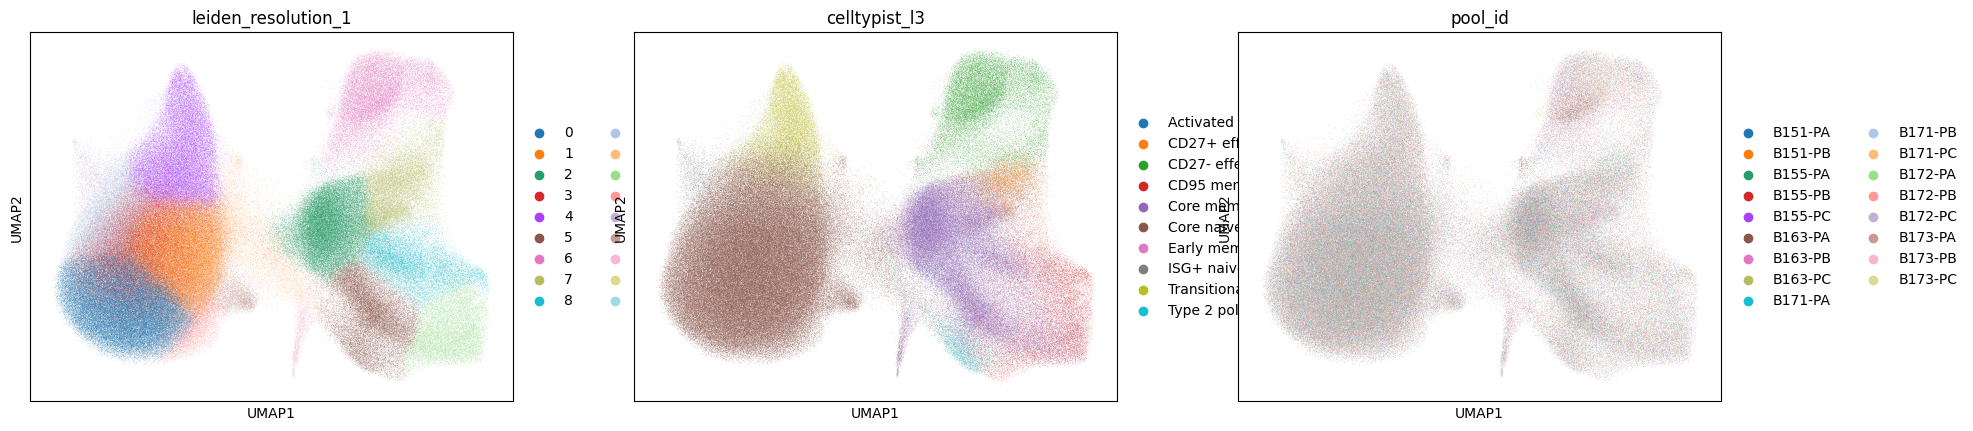

In [17]:
sc.pl.umap(adata, color=['leiden_resolution_1','celltypist_l3','pool_id'], ncols=3)

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


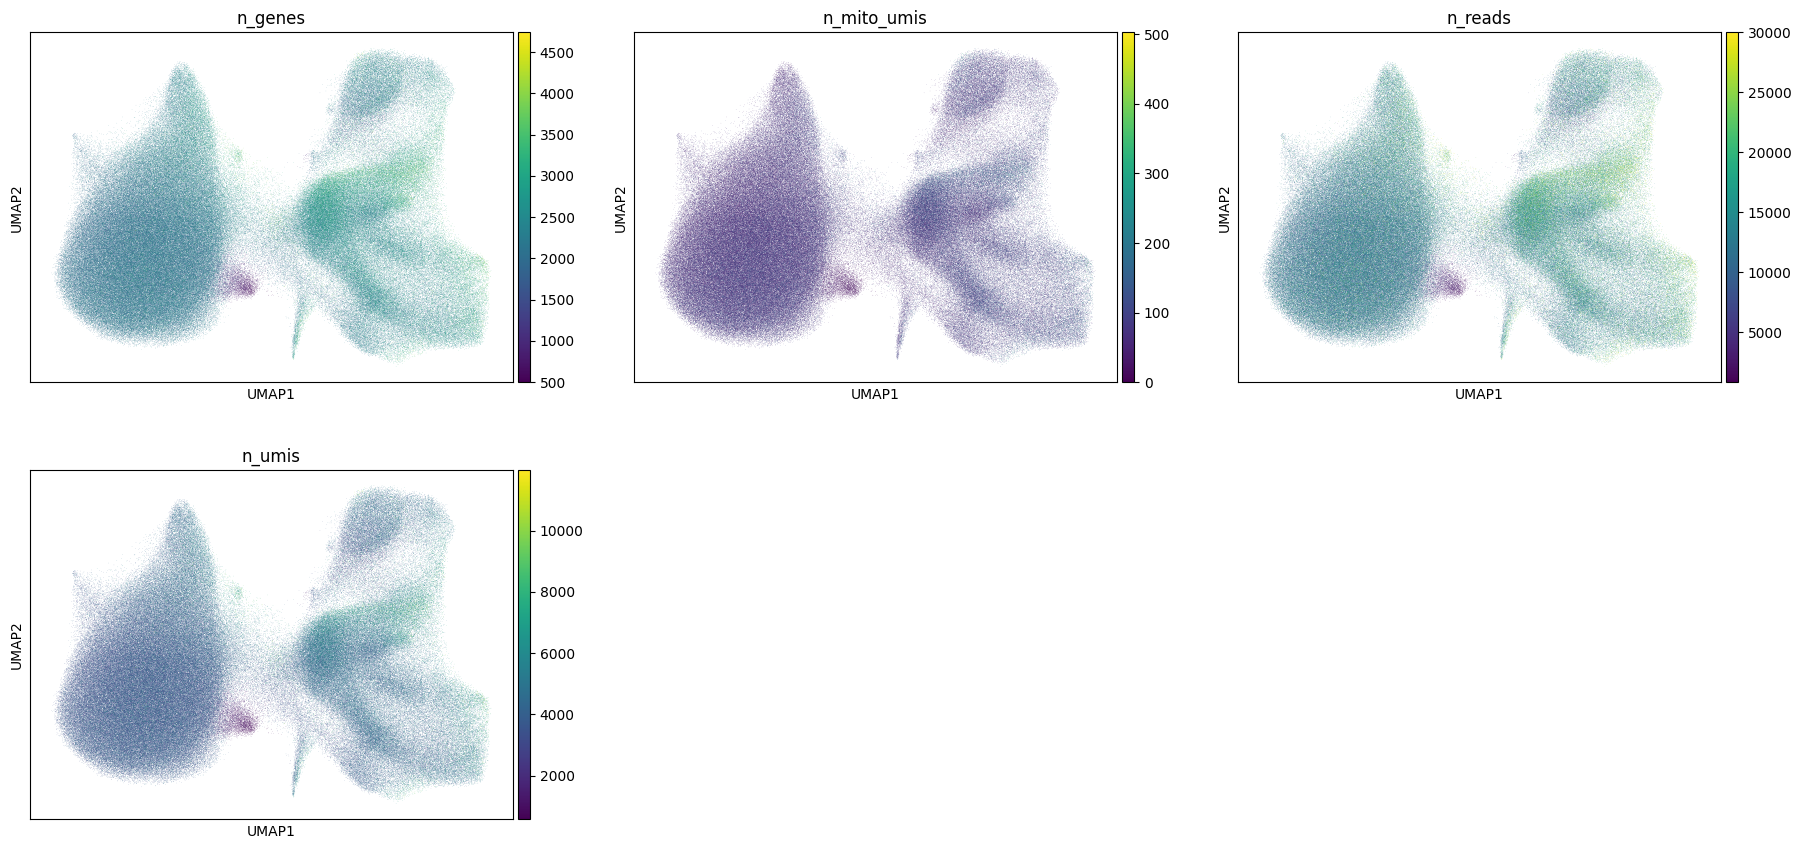

In [18]:
sc.pl.umap(adata, color=['n_genes', 'n_mito_umis', 'n_reads', 'n_umis'], ncols=3)

In [1]:
adata=sc.read_h5ad('Bcells_leiden.h5ad')

NameError: name 'sc' is not defined

In [20]:
adata.X[1:100].todense()

matrix([[ 0.,  0.,  0., ...,  2.,  3.,  4.],
        [ 0.,  0.,  0., ...,  1.,  4.,  6.],
        [ 0.,  1.,  1., ...,  3.,  3., 14.],
        ...,
        [ 0.,  0.,  0., ...,  2.,  4.,  2.],
        [ 0.,  1.,  1., ...,  0.,  4.,  4.],
        [ 0.,  1.,  0., ...,  3.,  3.,  9.]], dtype=float32)

In [21]:
adata.raw=adata
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [22]:
sc.tl.rank_genes_groups(adata, 'leiden_resolution_1', use_raw=False,method='t-test')

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future ve

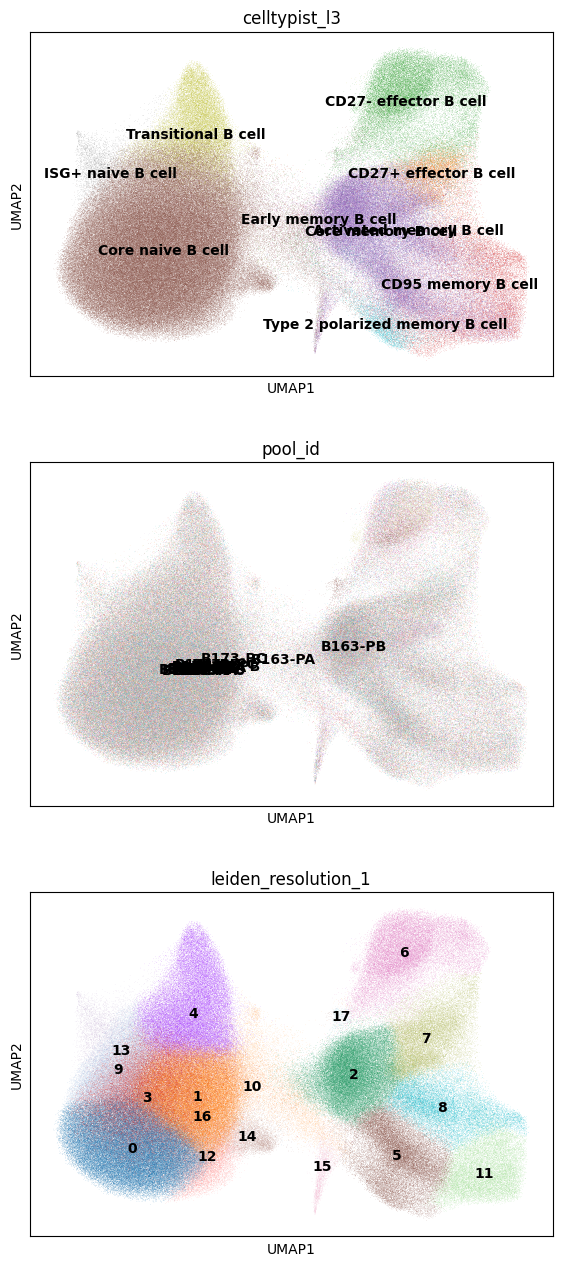

In [25]:
sc.pl.umap(adata, color=['celltypist_l3','pool_id','leiden_resolution_1'],legend_loc='on data', ncols=1)

/tmp/ipykernel_56630/4263555102.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = df.groupby('group').head(20).reset_index(drop=True)
/tmp/ipykernel_56630/4263555102.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = df.groupby('group')


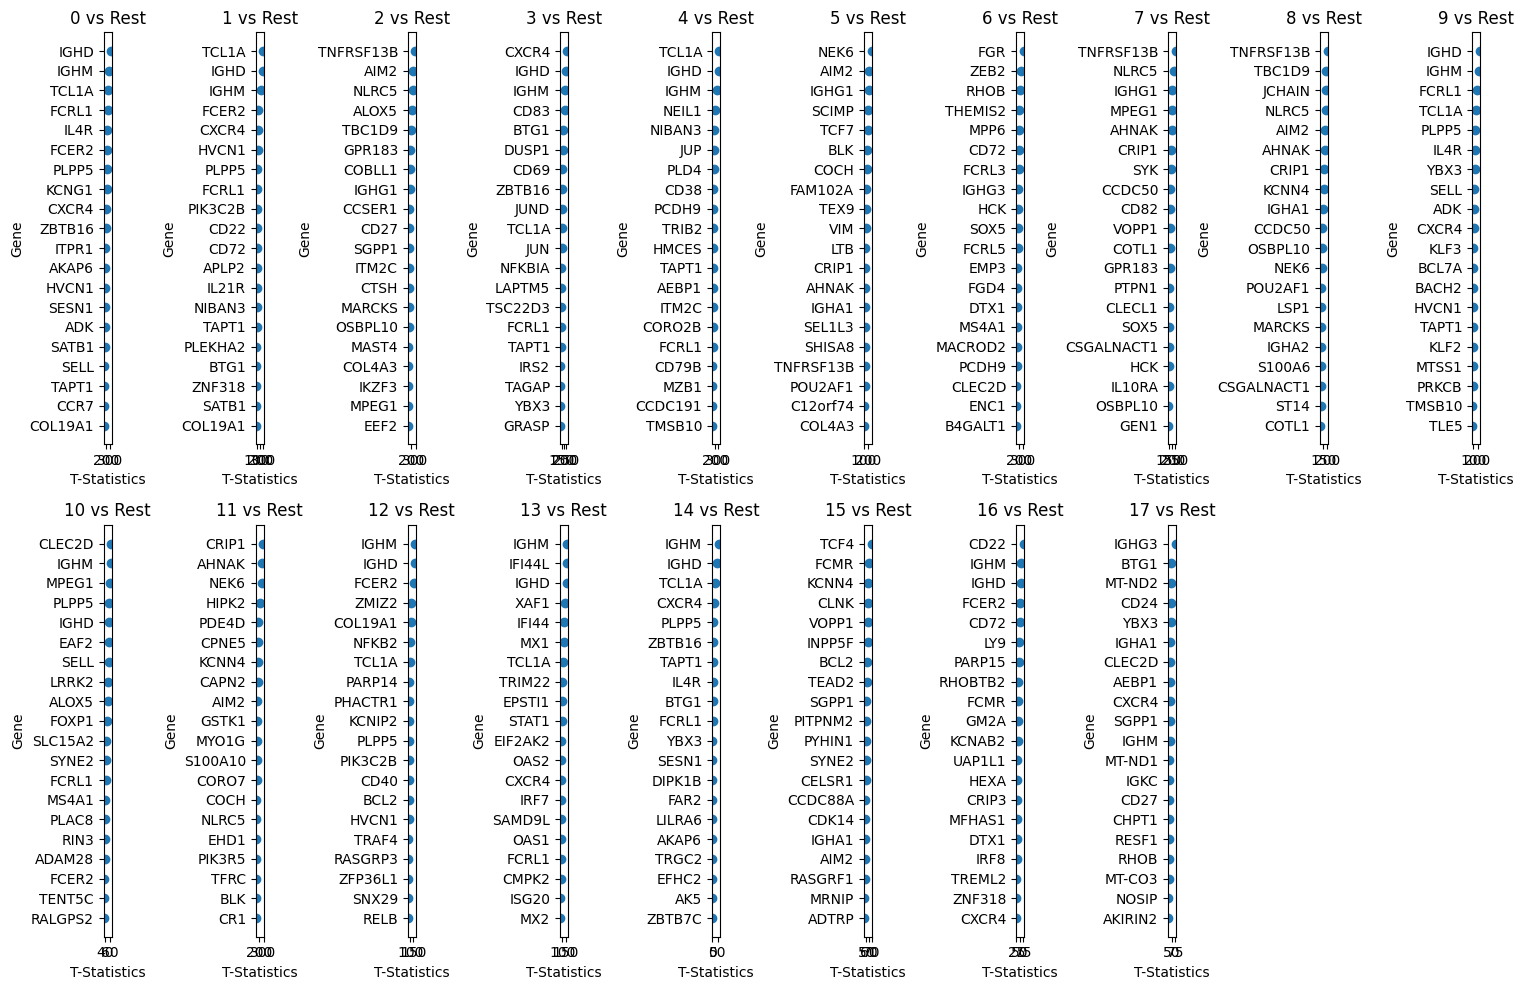

In [26]:
df = sc.get.rank_genes_groups_df(adata, group=None)
df = df.groupby('group').head(20).reset_index(drop=True)
groups = df.groupby('group')

n_groups = len(groups)
n_cols = 10
n_rows = math.ceil(n_groups / n_cols)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))

if n_rows == 1:
    axs = axs.reshape(1, -1)

for ax in axs.flat:
    ax.set_visible(False)

for i, (name, group) in enumerate(groups):
    row, col = divmod(i, n_cols)
    ax = axs[row, col]
    ax.set_visible(True)
    ax.scatter(group['scores'], group['names'])
    ax.invert_yaxis()
    ax.set_title(str(name) + " vs Rest")
    ax.set_xlabel('T-Statistics')
    ax.set_ylabel('Gene')

plt.tight_layout()